# Reddit r/diabetes Subreddit Scraper

This notebook demonstrates how to use PRAW (Python Reddit API Wrapper) to scrape data from the r/diabetes subreddit. You'll be able to collect posts, comments, and other information for analysis.

## Setup and Authentication

Before using PRAW, you need to set up a Reddit API application:

1. Go to https://www.reddit.com/prefs/apps
2. Click "create app" or "create another app" at the bottom
3. Fill in the details:
   - Name: YourAppName
   - Select "script"
   - Description: A brief description
   - About URL: (can be left blank for personal use)
   - Redirect URI: http://localhost:8080
4. Click "create app"
5. Note your client ID (the string under the app name) and client secret

You'll use these credentials in the code below.

In [1]:
# Install required packages
!pip install praw pandas matplotlib wordcloud nltk

  Using cached praw-7.8.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached prawcore-2.4.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached update_checker-0.18.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached websocket_client-1.8.0-py3-none-any.whl.metadata (8.0 kB)
  Using cached urllib3-1.25.11-py2.py3-none-any.whl.metadata (41 kB)
Using cached praw-7.8.1-py3-none-any.whl (189 kB)
Using cached prawcore-2.4.0-py3-none-any.whl (17 kB)
Using cached update_checker-0.18.0-py3-none-any.whl (7.0 kB)
Using cached websocket_client-1.8.0-py3-none-any.whl (58 kB)
Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0


In [1]:
# Import necessary libraries
import praw
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

/Users/seanmacbook/GitHub/healthapp_web_scrapper/.venv/lib/python3.13/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Connect to Reddit API

Replace the placeholders with your actual Reddit API credentials.

In [2]:
# Initialize the Reddit API client
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

reddit = praw.Reddit(
    client_id= os.getenv('CLIENT_ID'),        # Replace with your client ID
    client_secret= os.getenv('CLIENT_SECRET'),   # Replace with your client secret
    user_agent= os.getenv('USER_AGNET'),   # Replace with your username
    #username='YOUR_USERNAME',           # Replace with your Reddit username (optional for read-only)
    #password='YOUR_PASSWORD'            # Replace with your Reddit password (optional for read-only)
)

# For read-only access, you can use this simplified version:
# reddit = praw.Reddit(
#     client_id='YOUR_CLIENT_ID',
#     client_secret='YOUR_CLIENT_SECRET',
#     user_agent='script:diabetes_data_scraper:v1.0 (by /u/YOUR_USERNAME)'
# )

# Access the diabetes subreddit
subreddit = reddit.subreddit('diabetes')

print(f"Successfully connected to r/{subreddit.display_name}")
print(f"Subscribers: {subreddit.subscribers}")
print(f"Description: {subreddit.public_description[:100]}...")

Successfully connected to r/diabetes
Subscribers: 140590
Description: For humans living with diabetes: discussion, issues, and news....


# Initialize the Reddit API client
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

reddit = praw.Reddit(
    client_id= 'nwgosLu_7wOlLrpt4cFDaw',        # Replace with your client ID
    client_secret= '1Nf-zfbBkH2q_-OguypJOsaH7M_ZTg',   # Replace with your client secret
    user_agent= 'script:diabetes_data_scraper:v1.0 (by /u/w-61)',   # Replace with your username
    #username='YOUR_USERNAME',           # Replace with your Reddit username (optional for read-only)
    #password='YOUR_PASSWORD'            # Replace with your Reddit password (optional for read-only)
)

# For read-only access, you can use this simplified version:
# reddit = praw.Reddit(
#     client_id='YOUR_CLIENT_ID',
#     client_secret='YOUR_CLIENT_SECRET',
#     user_agent='script:diabetes_data_scraper:v1.0 (by /u/YOUR_USERNAME)'
# )

# Access the diabetes subreddit
subreddit = reddit.subreddit('diabetes')

print(f"Successfully connected to r/{subreddit.display_name}")
print(f"Subscribers: {subreddit.subscribers}")
print(f"Description: {subreddit.public_description[:100]}...")

## Scrape Recent Posts

Let's collect the most recent posts from the subreddit.

In [4]:
def scrape_posts(listing, limit=100):
    """Scrape posts from a subreddit listing (hot, new, top, etc.)"""
    posts_data = []
    
    for post in listing(limit=limit):
        # Extract post data
        post_data = {
            'id': post.id,
            'title': post.title,
            'score': post.score,
            'upvote_ratio': post.upvote_ratio,
            'created_utc': datetime.datetime.fromtimestamp(post.created_utc),
            'author': str(post.author),  # Convert to string in case author is deleted
            'num_comments': post.num_comments,
            'permalink': post.permalink,
            'url': post.url,
            'is_self': post.is_self,
            'selftext': post.selftext if post.is_self else '',
            'link_flair_text': post.link_flair_text,
            'over_18': post.over_18
        }
        posts_data.append(post_data)
        
    return pd.DataFrame(posts_data)

# Scrape recent posts
recent_posts_df = scrape_posts(subreddit.new)
print(f"Scraped {len(recent_posts_df)} recent posts")
recent_posts_df.head()

Scraped 100 recent posts


,id,title,score,upvote_ratio,created_utc,author,num_comments,permalink,url,is_self,selftext,link_flair_text,over_18
0,1jtxgku,From 12.5 to 5.2,1,1.0,2025-04-07 17:54:37,alienfrom818,0,/r/diabetes/comments/1jtxgku/from_125_to_52/,https://www.reddit.com/r/diabetes/comments/1jt...,True,I was diagnosed with type 2 in December. Tell ...,News,False
1,1jtweqa,The Omnipod Struggle,1,1.0,2025-04-07 17:08:44,Neither_Mistake_2013,0,/r/diabetes/comments/1jtweqa/the_omnipod_strug...,https://www.reddit.com/r/diabetes/comments/1jt...,True,Hi! \n\nI'm struggling so much with my blood s...,Type 1,False
2,1jtwnf4,Accidentally threw away my metformin and havin...,5,1.0,2025-04-07 17:18:56,Huge_World_3125,9,/r/diabetes/comments/1jtwnf4/accidentally_thre...,https://www.reddit.com/r/diabetes/comments/1jt...,True,Why does everything have to be so complicated?...,Rant,False
3,1jtwjzm,Pen Dosage Capacity,1,1.0,2025-04-07 17:14:54,StarrySkiesNY,1,/r/diabetes/comments/1jtwjzm/pen_dosage_capacity/,https://www.reddit.com/r/diabetes/comments/1jt...,True,ELI5 please!\n\n100 U/Ml pens of Fiasp insulin...,Medication,False
4,1jtvlxo,Exercise made me worse??,1,1.0,2025-04-07 16:36:01,Imaginary-Sun-188,2,/r/diabetes/comments/1jtvlxo/exercise_made_me_...,https://www.reddit.com/r/diabetes/comments/1jt...,True,Off I went on a two week vacation to the Barce...,Discussion,False


## Scrape Hot Posts

In [5]:
# Scrape hot posts
hot_posts_df = scrape_posts(subreddit.hot)
print(f"Scraped {len(hot_posts_df)} hot posts")
hot_posts_df.head()

Scraped 100 hot posts


,id,title,score,upvote_ratio,created_utc,author,num_comments,permalink,url,is_self,selftext,link_flair_text,over_18
0,1cvnqym,Weekly r/diabetes vent thread,30,0.95,2024-05-19 09:00:31,AutoModerator,167,/r/diabetes/comments/1cvnqym/weekly_rdiabetes_...,https://www.reddit.com/r/diabetes/comments/1cv...,True,Tell us the crap you're dealing with this week...,Discussion,False
1,1jnbw9f,Weekly r/diabetes vent thread,8,0.84,2025-03-30 09:00:49,AutoModerator,28,/r/diabetes/comments/1jnbw9f/weekly_rdiabetes_...,https://www.reddit.com/r/diabetes/comments/1jn...,True,Tell us the crap you're dealing with this week...,Discussion,False
2,1jt874e,My CGM line drew a happy face :D,284,1.00,2025-04-06 20:03:15,supermouse35,11,/r/diabetes/comments/1jt874e/my_cgm_line_drew_...,https://i.redd.it/5j4je9he0bte1.jpeg,False,,Type 2,False
3,1jtuvc9,Anyone here tried Stevia after cutting out sug...,8,1.00,2025-04-07 16:05:42,gavvy__,17,/r/diabetes/comments/1jtuvc9/anyone_here_tried...,https://i.redd.it/bmb8hz4wygte1.jpeg,False,,Type 1,False
4,1jtwnf4,Accidentally threw away my metformin and havin...,5,1.00,2025-04-07 17:18:56,Huge_World_3125,9,/r/diabetes/comments/1jtwnf4/accidentally_thre...,https://www.reddit.com/r/diabetes/comments/1jt...,True,Why does everything have to be so complicated?...,Rant,False


## Scrape Top Posts of All Time

In [6]:
# Scrape top posts of all time
top_posts_df = scrape_posts(subreddit.top)
print(f"Scraped {len(top_posts_df)} top posts")
top_posts_df.head()

Scraped 100 top posts


,id,title,score,upvote_ratio,created_utc,author,num_comments,permalink,url,is_self,selftext,link_flair_text,over_18
0,ysngrl,Eli Lilly should apologize,2670,0.98,2022-11-11 16:18:07,eloquinee,161,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,https://i.redd.it/uwysttgz1ez91.jpg,False,,Healthcare,False
1,lsxbfp,Nobody really saw my tweet so I thought you lo...,1790,0.99,2021-02-26 08:06:07,guiltyandfast,94,/r/diabetes/comments/lsxbfp/nobody_really_saw_...,https://i.redd.it/7j7a1i2bmtj61.jpg,False,,Humor,False
2,akcrtf,Price regulation needed,1774,0.98,2019-01-27 10:10:43,Sweatyfatmess,229,/r/diabetes/comments/akcrtf/price_regulation_n...,https://i.redd.it/n3f5x2duezc21.jpg,False,,Supplies,False
3,mv1lwc,Had to be posted today...,1659,1.00,2021-04-20 18:02:30,Maireadmc13,68,/r/diabetes/comments/mv1lwc/had_to_be_posted_t...,https://i.redd.it/2wg783fbieu61.jpg,False,,Humor,False
4,md3zwy,How it goes trying to dose insulin every day,1632,0.99,2021-03-25 13:46:16,free_chalupas,65,/r/diabetes/comments/md3zwy/how_it_goes_trying...,https://i.redd.it/a9lppnrvo7p61.png,False,,Humor,False


## Save Posts to CSV Files

In [8]:
# Save to CSV files
recent_posts_df.to_csv('../data/interim/diabetes_recent_posts.csv', index=False)
hot_posts_df.to_csv('../data/interim/diabetes_hot_posts.csv', index=False)
top_posts_df.to_csv('../data/interim/diabetes_top_posts.csv', index=False)

print("Saved posts to CSV files")

Saved posts to CSV files


## Scrape Comments from Top Posts

Now let's collect comments from the top posts.

In [9]:
def scrape_comments(post_id, limit=None):
    """Scrape comments from a post"""
    post = reddit.submission(id=post_id)
    comments_data = []
    
    # Replace MoreComments objects with actual comments (up to limit)
    post.comments.replace_more(limit=limit)
    
    # Function to process comments recursively
    def process_comment(comment, level=0):
        comment_data = {
            'id': comment.id,
            'post_id': post_id,
            'parent_id': comment.parent_id,
            'body': comment.body,
            'score': comment.score,
            'created_utc': datetime.datetime.fromtimestamp(comment.created_utc),
            'author': str(comment.author),  # Convert to string in case author is deleted
            'is_submitter': comment.is_submitter,
            'permalink': comment.permalink,
            'level': level
        }
        comments_data.append(comment_data)
        
        # Process replies
        for reply in comment.replies:
            process_comment(reply, level + 1)
    
    # Process all top-level comments
    for comment in post.comments:
        process_comment(comment)
        
    return pd.DataFrame(comments_data)

# Get comments from the top 5 posts
all_comments_df = pd.DataFrame()

for i, post_id in enumerate(top_posts_df['id'].head(5)):
    print(f"Scraping comments from post {i+1}/5: {post_id}")
    comments_df = scrape_comments(post_id, limit=10)  # Limit to 10 MoreComments expansions per post
    all_comments_df = pd.concat([all_comments_df, comments_df], ignore_index=True)
    time.sleep(2)  # Be nice to Reddit's servers

print(f"Scraped {len(all_comments_df)} comments from top 5 posts")
all_comments_df.head()

Scraping comments from post 1/5: ysngrl
Scraping comments from post 2/5: lsxbfp
Scraping comments from post 3/5: akcrtf
Scraping comments from post 4/5: mv1lwc
Scraping comments from post 5/5: md3zwy
Scraped 632 comments from top 5 posts


,id,post_id,parent_id,body,score,created_utc,author,is_submitter,permalink,level
0,iw08501,ysngrl,t3_ysngrl,"All these people care about is money, they don...",137,2022-11-11 17:47:37,Foreign-Concept5567,False,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,0
1,iw1p3in,ysngrl,t1_iw08501,"I was born in a war torn, impoverished eastern...",46,2022-11-12 01:52:44,nixa919,False,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,1
2,iw402zp,ysngrl,t1_iw1p3in,It's US$7.28 in my country for a cartridge.\n\...,7,2022-11-12 15:03:20,Doughspun1,False,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,2
3,iygcmkw,ysngrl,t1_iw402zp,insulin is incredibly cheap to make so its jus...,2,2022-11-30 23:30:21,eniminimini,False,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,3
4,iw1eh8t,ysngrl,t1_iw08501,They only want you to live long enough for you...,21,2022-11-11 23:49:46,freddyt55555,False,/r/diabetes/comments/ysngrl/eli_lilly_should_a...,1


In [10]:
# Save comments to CSV
all_comments_df.to_csv('./data/interim/diabetes_comments.csv', index=False)
print("Saved comments to CSV file")

OSError: Cannot save file into a non-existent directory: 'data/interim'

## Data Analysis and Visualization

Let's analyze and visualize some of the scraped data.

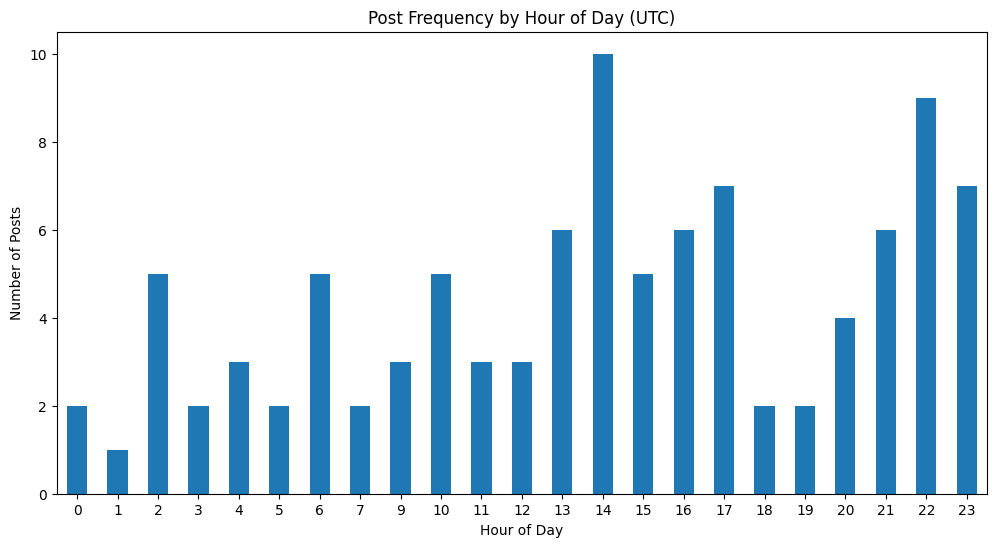

In [11]:
# Get post frequency by time of day
recent_posts_df['hour'] = recent_posts_df['created_utc'].dt.hour

plt.figure(figsize=(12, 6))
recent_posts_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Post Frequency by Hour of Day (UTC)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.show()

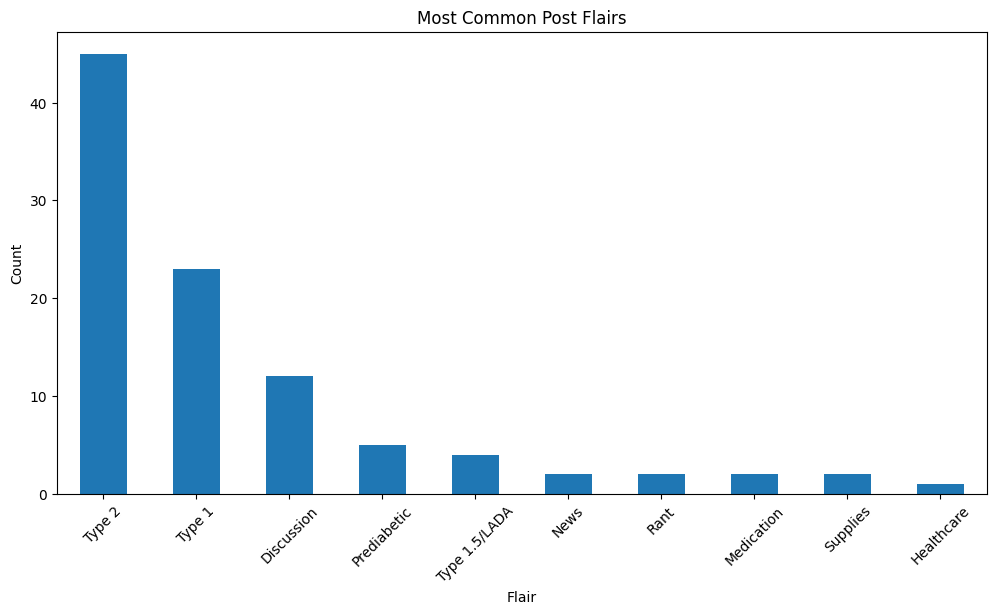

In [12]:
# Get most common post flairs
plt.figure(figsize=(12, 6))
flair_counts = recent_posts_df['link_flair_text'].dropna().value_counts().head(10)
flair_counts.plot(kind='bar')
plt.title('Most Common Post Flairs')
plt.xlabel('Flair')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

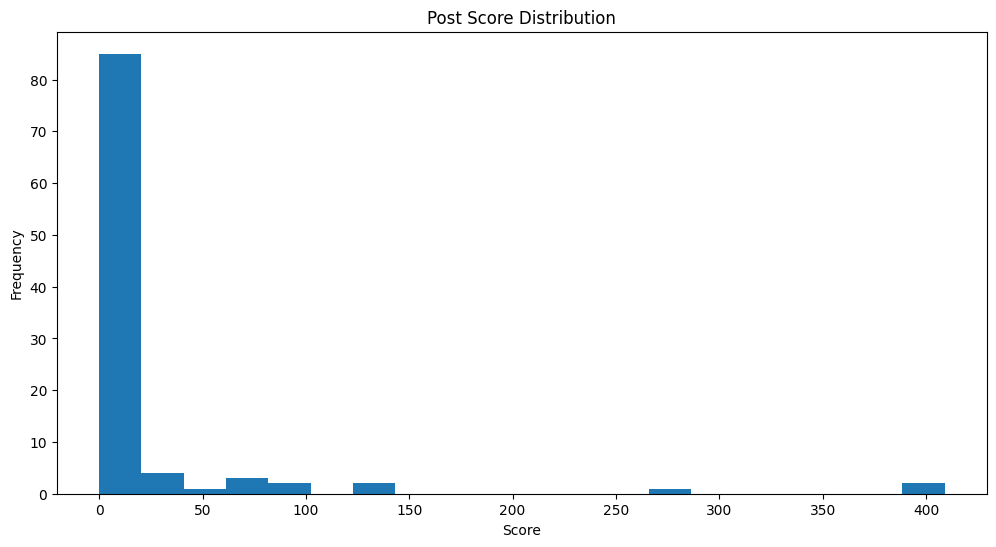

In [13]:
# Post score distribution
plt.figure(figsize=(12, 6))
plt.hist(recent_posts_df['score'], bins=20)
plt.title('Post Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

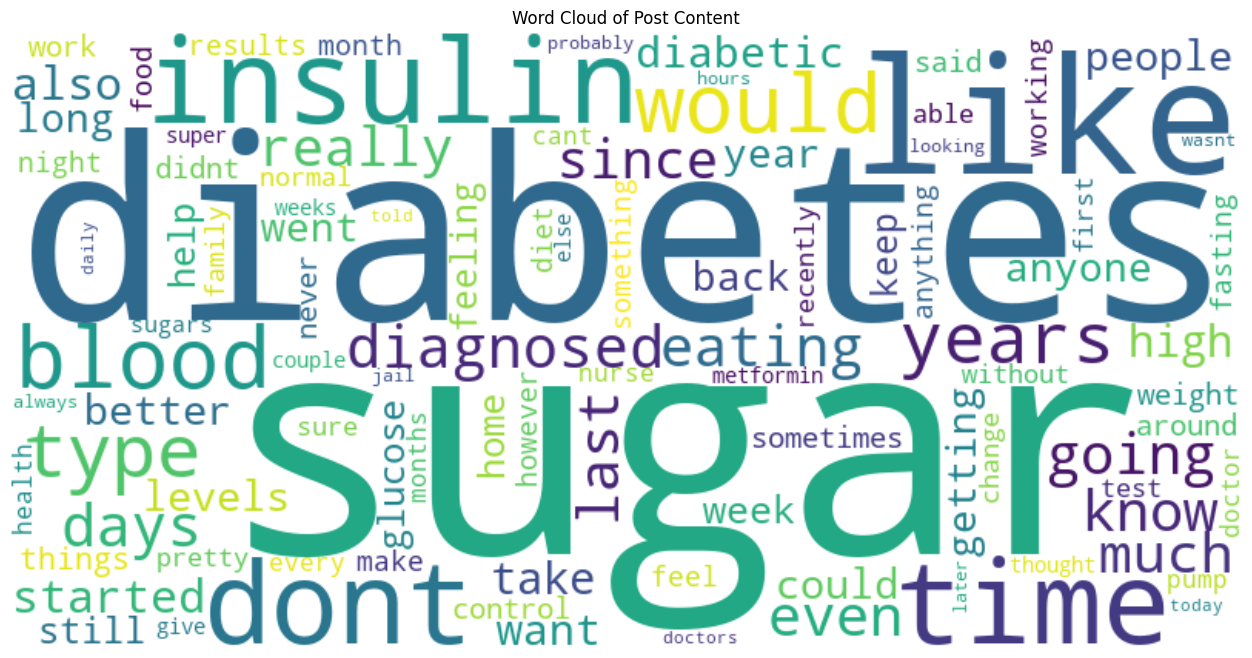

In [14]:
# Create word cloud from post titles and text
def create_word_cloud(text_series):
    # Combine all text
    combined_text = ' '.join(text_series.fillna(''))
    
    # Clean text
    cleaned_text = re.sub(r'[^\w\s]', '', combined_text.lower())
    
    # Tokenize
    words = nltk.word_tokenize(cleaned_text)
    
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words and len(word) > 3]
    
    # Count words
    word_counts = Counter(filtered_words)
    
    # Create wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(word_counts)
    
    # Display
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Post Content')
    plt.show()

# Combine titles and selftext (for text posts)
recent_posts_df['combined_text'] = recent_posts_df['title'] + ' ' + recent_posts_df['selftext']
create_word_cloud(recent_posts_df['combined_text'])

## Analyze Comment Sentiment (Optional)

You can add sentiment analysis to better understand the emotional tone of comments.

  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
  Using cached urllib3-1.25.11-py2.py3-none-any.whl.metadata (41 kB)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/seanmacbook/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


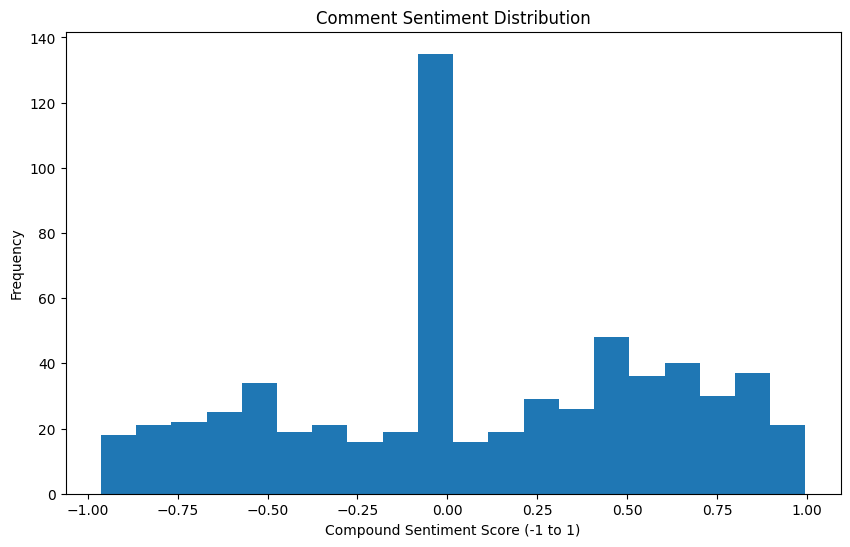

In [15]:
# Install and import VADER for sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK sentiment analyzers
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    if pd.isna(text) or text == '':
        return None
    return analyzer.polarity_scores(text)

# Apply sentiment analysis to comments
all_comments_df['sentiment'] = all_comments_df['body'].apply(get_sentiment)
all_comments_df['compound_score'] = all_comments_df['sentiment'].apply(lambda x: x['compound'] if x else None)

# Plot sentiment distribution
plt.figure(figsize=(10, 6))
plt.hist(all_comments_df['compound_score'].dropna(), bins=20)
plt.title('Comment Sentiment Distribution')
plt.xlabel('Compound Sentiment Score (-1 to 1)')
plt.ylabel('Frequency')
plt.show()

## Search for Specific Topics

Let's search for specific diabetes-related topics in the subreddit.

In [16]:
def search_subreddit(query, limit=100):
    """Search the subreddit for a specific query"""
    posts_data = []
    
    for post in subreddit.search(query, limit=limit):
        # Extract post data (same as before)
        post_data = {
            'id': post.id,
            'title': post.title,
            'score': post.score,
            'created_utc': datetime.datetime.fromtimestamp(post.created_utc),
            'author': str(post.author),
            'num_comments': post.num_comments,
            'permalink': post.permalink,
            'selftext': post.selftext if post.is_self else '',
            'link_flair_text': post.link_flair_text
        }
        posts_data.append(post_data)
        
    return pd.DataFrame(posts_data)

# Search for some common diabetes-related terms
search_terms = ['insulin', 'CGM', 'A1C', 'pump', 'low carb']
search_results = {}

for term in search_terms:
    print(f"Searching for '{term}'...")
    search_results[term] = search_subreddit(term, limit=50)
    print(f"Found {len(search_results[term])} posts")
    time.sleep(2)  # Be nice to Reddit's servers

Searching for 'insulin'...
Found 50 posts
Searching for 'CGM'...
Found 50 posts
Searching for 'A1C'...
Found 50 posts
Searching for 'pump'...
Found 50 posts
Searching for 'low carb'...
Found 50 posts


In [17]:
# Compare popularity of different topics
topic_stats = []

for term, df in search_results.items():
    stats = {
        'topic': term,
        'post_count': len(df),
        'avg_score': df['score'].mean(),
        'avg_comments': df['num_comments'].mean(),
        'recent_post_count': sum(df['created_utc'] > (datetime.datetime.now() - datetime.timedelta(days=30)))
    }
    topic_stats.append(stats)

topic_stats_df = pd.DataFrame(topic_stats)
topic_stats_df

,topic,post_count,avg_score,avg_comments,recent_post_count
0,insulin,50,326.66,130.64,3
1,CGM,50,87.94,63.28,11
2,A1C,50,156.38,63.64,8
3,pump,50,128.24,43.56,11
4,low carb,50,38.56,51.84,6


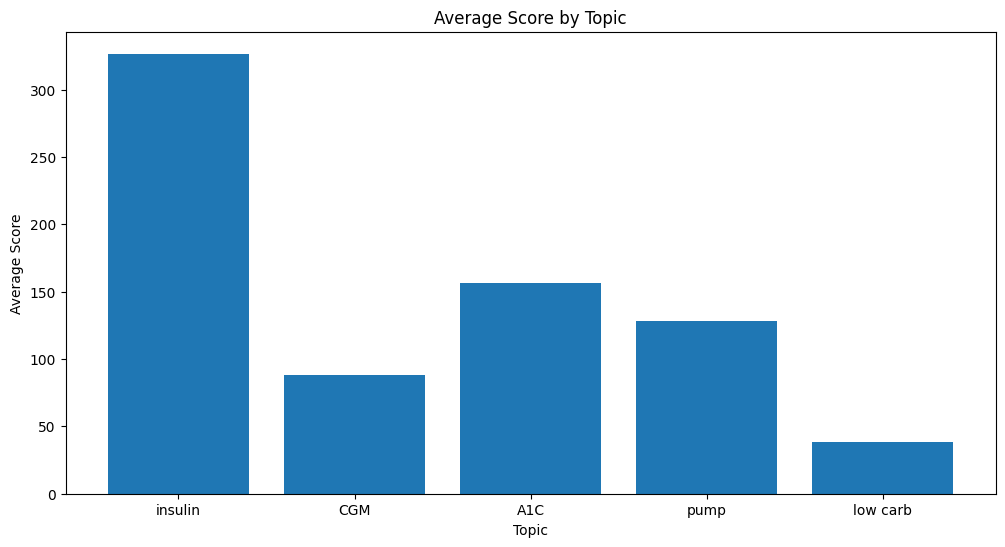

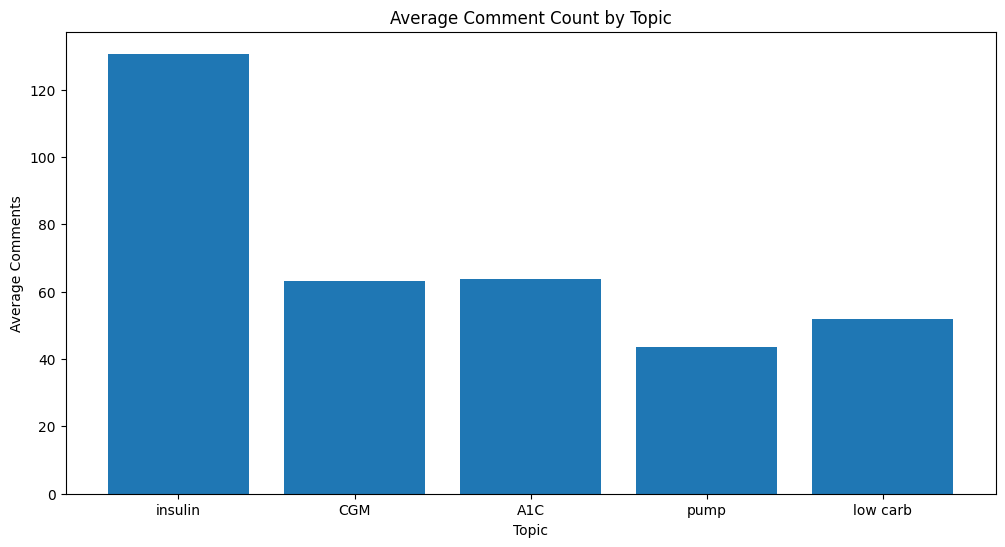

In [18]:
# Visualize topic popularity
plt.figure(figsize=(12, 6))
plt.bar(topic_stats_df['topic'], topic_stats_df['avg_score'])
plt.title('Average Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Score')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(topic_stats_df['topic'], topic_stats_df['avg_comments'])
plt.title('Average Comment Count by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Comments')
plt.show()

## Monitor the Subreddit in Real-time (Optional)

You can also set up a stream to monitor new posts and comments in real-time.

In [19]:
def monitor_subreddit(duration_seconds=60):
    """Monitor the subreddit for new submissions for a specified duration"""
    print(f"Monitoring r/{subreddit.display_name} for {duration_seconds} seconds...")
    start_time = time.time()
    
    for submission in subreddit.stream.submissions():
        elapsed_time = time.time() - start_time
        if elapsed_time > duration_seconds:
            break
            
        print(f"\nNew post detected at {datetime.datetime.now()}:")
        print(f"Title: {submission.title}")
        print(f"Author: {submission.author}")
        print(f"URL: https://www.reddit.com{submission.permalink}")
        
    print("\nMonitoring complete.")

# Uncomment to monitor the subreddit for 60 seconds
# monitor_subreddit(60)

## Conclusion

This notebook demonstrates how to use PRAW to scrape and analyze data from the r/diabetes subreddit. You can extend this to:

1. Collect more comprehensive data over time
2. Perform more advanced text analysis
3. Create a dashboard for monitoring diabetic topics and trends
4. Analyze user behavior and community engagement

Remember to respect Reddit's API rules and rate limits, and to be mindful of privacy considerations when analyzing user data.

## Important Notes on Ethical Web Scraping

When scraping Reddit or any website, always:

1. Follow the site's Terms of Service and robots.txt rules
2. Respect rate limits to avoid overloading servers
3. Be transparent about your scraping activities
4. Anonymize any personal data you collect
5. Use the data responsibly, especially for health-related topics

Reddit's API has specific rules about scraping. Always check the latest [Reddit API Terms](https://www.redditinc.com/policies/data-api-terms) before proceeding.